In [2]:
import numpy as np
import matplotlib.pyplot as plt

0.1
0.2
0.3
0.4
0.5


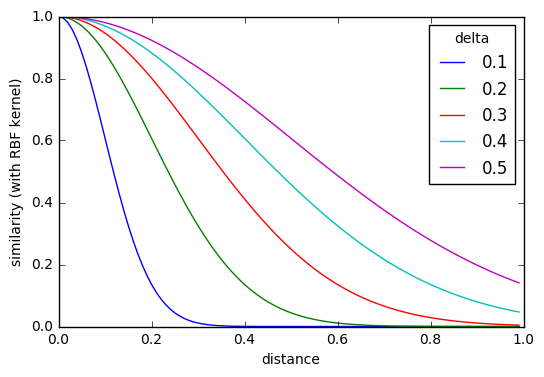

In [3]:
delta = 0.5

dist =x= np.arange(0,1, 0.01)

for delta in np.arange(0.1,0.6, 0.1):
    print(delta)
    gaussian_sim = np.exp(- dist ** 2 / (2. * delta ** 2))
    plt.plot(x, gaussian_sim, label=delta)
# np.exp(- 1 ** 2 / (2. * delta ** 2))
plt.legend(title="delta")
plt.xlabel('distance')
plt.ylabel('similarity (with RBF kernel)')
plt.show()

In [ ]:
def get_contexts(filename, apple=True, ):
    print(filename)
    w_index = filename.index('w_')
    window = filename[w_index+2]
    symmetric = filename[w_index+6] == 'T'
#     print(window, symmetric)
    apple_contexts = open('../datasets/apple_contexts_s_{}_w_{}.txt'.format(symmetric, window)).read().splitlines()
    rock_contexts = open('../datasets/rock_contexts_s_{}_w_{}.txt'.format(symmetric, window)).read().splitlines()
    pear_contexts = open('../datasets/pear_contexts_s_{}_w_{}.txt'.format(symmetric, window)).read().splitlines()
    contexts = apple_contexts + rock_contexts + pear_contexts
    labels = [0]*len(apple_contexts) + [1]*len(rock_contexts) + [2]*len(pear_contexts)
    return labels


def get_contexts(window, symmetric, apple=True, rock=True, pear=True):
    print(window, symmetric, apple, rock, pear)
    apple_contexts = []
    rock_contexts = []
    pear_contexts = []
    if apple:
        with open('../datasets/apple_contexts_s_{}_w_{}.txt'.format(symmetric, window)) as f:
            apple_contexts = f.read().splitlines()
    if rock:
        with open('../datasets/rock_contexts_s_{}_w_{}.txt'.format(symmetric, window)) as f:
            rock_contexts = f.read().splitlines()
    if pear:
        with open('../datasets/pear_contexts_s_{}_w_{}.txt'.format(symmetric, window)) as f:
            pear_contexts = f.read().splitlines()
    contexts = apple_contexts + rock_contexts + pear_contexts
    return contexts

### Decision Tree Clustering

In [ ]:

class DecisionTreeClustering:
    
    def __init__(self, min_cluster_fraction=0.2, max_depth=5, n_jobs=1):
        self.min_cluster_fraction = min_cluster_fraction
        self.max_depth = max_depth
        self.n_jobs = n_jobs
    
    def set_labels(self, rows, path):
        label = int(path)
        for index in rows:
            self.labels_[index] = label 
    
    def split_goodness(self, index0, index1):
        if len(index0) == 0 or len(index1) == 0:
            return 0
        indx0 = index0.reshape(-1,1)*self.cosine_similarities.shape[1] + index0
        indx1 = index1.reshape(-1,1)*self.cosine_similarities.shape[1] + index1
        split0 = self.cosine_similarities.take(indx0.flat)
        split1 = self.cosine_similarities.take(indx1.flat)
#         goodness = np.mean([np.mean(split0), np.mean(split1)])
        n0 = split0.shape[0]
        n1 = split1.shape[0]
        goodness = (n0*np.mean(split0) + n1*np.mean(split1))/(n0+n1)
#         goodness = min(len(indx0), len(indx1))
        return goodness
    
    def decision_walk(self, rows, path='1'):
#         print('walking', path)
#         goodnesses = Parallel(n_jobs=self.n_jobs)(delayed(self.split_goodness)(np.where(self.features[rows,i] == 0)[0], np.where(self.features[rows,i] == 1)[0]) for i in range(self.features.shape[1]))
#         goodnesses = parallel(delayed(self.split_goodness)(np.where(self.features[rows,i] == 0)[0], np.where(self.features[rows,i] == 1)[0]) for i in range(self.features.shape[1]))
        goodnesses = [self.split_goodness(np.where(self.features[rows,i] == 0)[0], np.where(self.features[rows,i] == 1)[0]) for i in range(self.features.shape[1])]
        
#         goodnesses = np.zeros(self.features.shape[1])
#         for i in range(self.features.shape[1]):
#             goodnesses[i] = self.split_goodness(np.where(self.features[rows,i] == 0)[0], np.where(self.features[rows,i] == 1)[0])
        
        goodnesses = np.array(goodnesses)
#         print(goodnesses)
        argmax = np.argwhere(goodnesses == np.max(goodnesses)).flatten()
        max_index = np.random.choice(argmax,1)
        rows0 = rows[np.argwhere(self.features[rows,max_index] == 0)[:,0]]
        rows1 = rows[np.argwhere(self.features[rows,max_index] == 1)[:,0]]
        if len(path) == self.max_depth:
            self.set_labels(rows1, path=path)
            self.set_labels(rows0, path=path)
            return
#         print('rows0 {} rows1 {}'.format(len(rows0), len(rows1)))
        if len(rows0) > self.min_cluster_size:
            self.decision_walk(rows0, path=path+'0')
        else:
            self.set_labels(rows0, path=path+'0')
        if len(rows1) > self.min_cluster_size:
            self.decision_walk(rows1, path=path+'1')
        else:
#             print('rows1 < min_cluster_size')
            self.set_labels(rows1, path=path+'1')
    
    def fit(self, cos_sim, features):
        self.labels_ = np.zeros(len(cos_sim))
        self.features = features
        self.cosine_similarities = cos_sim
        np.fill_diagonal(self.cosine_similarities, 0)
        rows = np.arange(self.features.shape[0])
        self.min_cluster_size = int(len(rows)*self.min_cluster_fraction)
        self.decision_walk(rows)



def generate_tfidf_clustered(contexts):
    tfidf_vectorizer = TfidfVectorizer()
    tfidf = tfidf_vectorizer.fit_transform(contexts).toarray()
    words = tfidf_vectorizer.get_feature_names()

    word_features = np.zeros((len(words), 100))
    missing_words = []
    for i, word in enumerate(words):
#         if word not in funky_words:
#             word_features[i,:] = word2vec_model[word]
#         else:
#             print(word)
#             word_features[i,:] = word2vec_model[funky_words[word]]
        try:
            word_features[i,:] = word2vec_model[word]
        except KeyError:
#             print(word)
#             word_estnltk = estnltk.Text(word).lemmas[0]
            new_lemma = lemmatize_and_vec_check(word)
            if new_lemma in word2vec_model:
                word_features[i,:] = word2vec_model[new_lemma]
            else:
                missing_words.append(i)
#                 print('ei leia', new_lemma, word, i)

#     print('missing, ', len(missing_words), missing_words)
    n_clusters = 20
    model = AgglomerativeClustering(n_clusters=n_clusters)
    model.fit(word_features)

    labels = model.labels_

    tfidf_clustered = np.zeros((tfidf.shape[0], n_clusters))

    for cluster_index in range(n_clusters):
    #     print(i)
        tfidf_clustered[:,cluster_index] = np.sum(tfidf[:,np.where(labels==cluster_index)[0]],axis=1)

    tfidf_clustered[tfidf_clustered>0] = 1

    return tfidf_clustered, missing_words

def lemmatize_and_vec_check(word):
    lemma = estnltk.Text(word).lemmas[0]
    if lemma in word2vec_model:
        return lemma
    
#     for letter in string.ascii_lowercase:
#         new_lemma = estnltk.Text(word+letter).lemmas[0]
#         if new_lemma in word2vec_model:
#             return new_lemma
#     if word[-2:] == 'ud':
# #         print(word, estnltk.Text(word[:-2]).lemmas[0], estnltk.Text(word[:-2]).lemmas[0] in word2vec_model)
#         return estnltk.Text(word[:-2]).lemmas[0]

def DecTreeExperiment(sim_filename):
    print(sim_filename)
    apple='apple' in sim_filename
    rock='rock' in sim_filename
    pear='pear' in sim_filename
    abbr = file_abbr(sim_filename)
    window, symmetric = parse_w_s(sim_filename)

    tfidf_clustered, missing_indexes = generate_tfidf_clustered(get_contexts(
            window=window, 
            symmetric=symmetric, 
            apple=apple, 
            rock=rock, 
            pear=pear))

    sim = np.load(sim_filename)

    results = []

    for max_depth in [5, 10, 20]:
        print(max_depth)
        model = DecisionTreeClustering(max_depth=max_depth, n_jobs=1)
#         model.fit(sim[:1000,:1000], tfidf_clustered[:1000])
        model.fit(sim, tfidf_clustered)
        
        homo_score = homogeneity_score(get_true_labels(sim_filename), model.labels_)
        print(homo_score)
        n_clusters = len(set(model.labels_))
        res = {'n_clusters': n_clusters, 'sim_file': sim_filename, 'homogeneity_score': homo_score}
        pickle.dump(res, open("apple-rock-pear-results/dec-tree/abbr_{}_d_{}_f_{}_sampled_{}.p".format(abbr, max_depth, os.path.split(sim_filename)[-1], 'sampled' in sim_filename), "wb" ))


Parallel(n_jobs=14)(delayed(DecTreeExperiment)(filename) for filename in sim_files)
# DecTreeExperiment(sim_files[0])